In [1]:
# Uncomment this code if you are running on Google Colab
# ! pip install https://github.com/rcpaffenroth/generatedata
# ! pip install https://github.com/rcpaffenroth/iterativennsimple

<a href="https://colab.research.google.com/github/rcpaffenroth/iterativennsimple/blob/main/notebooks/advanced/6-rcp-Sequential2D-training-spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Singular Value Spectra Evolution During Training

This notebook explores how the singular value spectra of weight matrices evolve during training for two different Sequential2D architectures.

## Problem Setup

**Regression Task**: Predict the Euclidean norm (L2 length) of an input vector

Given input $\mathbf{x} \in \mathbb{R}^d$, predict:

$$y = \|\mathbf{x}\|_2 = \sqrt{x_1^2 + x_2^2 + \cdots + x_d^2}$$

## Two Model Architectures

### Model 1: Chain Architecture (Superdiagonal)
A traditional feedforward network with sequential transformations:
- Only superdiagonal blocks are filled (F1, F2, F3)
- Information flows linearly through layers
- 3 trainable weight matrices

### Model 2: Dense Lateral Architecture
A fully connected block matrix with all lateral connections:
- All blocks above diagonal are filled (G01, G02, G03, G11, G12, G13, G21, G22, G23, G31, G32, G33)
- Information can skip layers directly
- 12 trainable weight matrices

## Analysis Goals

For each weight matrix $W$, we compute its singular value decomposition:

$$W = U\Sigma V^T$$

where $\Sigma = \text{diag}(\sigma_1, \sigma_2, \ldots, \sigma_r)$ with $\sigma_1 \geq \sigma_2 \geq \cdots \geq \sigma_r \geq 0$.

We visualize:
1. Individual block spectra evolution
2. Combined spectra across all blocks
3. Condition numbers and numerical properties

## Setup and Imports

In [2]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from iterativennsimple.Sequential2D import Sequential2D, Identity
from iterativennsimple.Sequential1D import Sequential1D
from iterativennsimple.MaskedLinear import MaskedLinear

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Hyperparameters

Define all key parameters at the top for easy modification.

In [3]:
# Model architecture dimensions
input_size = 8      # Input vector dimension
hidden_size_1 = 16  # First hidden layer size
hidden_size_2 = 16  # Second hidden layer size
output_size = 1     # Output dimension (scalar norm)

# Training parameters
n_train = 1000      # Number of training samples
n_val = 200         # Number of validation samples
batch_size = 32     # Batch size for training
n_epochs = 50       # Number of training epochs
learning_rate = 0.001  # Learning rate for Adam optimizer

# Iteration parameters for Sequential2D
n_iters_model1 = 3  # Model 1 needs 3 iterations (chain)
n_iters_model2 = 4  # Model 2 needs 4 iterations (full block matrix)

# model2 sparsity
sparsity = 0.25  # 25% sparsity in the weight matrices

# Checkpointing for spectral analysis
checkpoint_epochs = [0, 5, 10, 20, 30, 40, 49]  # Epochs to save spectra

## Dataset Generation

Generate synthetic training and validation data for the regression task.

In [4]:
def generate_norm_data(n_samples, input_dim, device='cpu'):
    """
    Generate synthetic data for predicting Euclidean norm.
    
    Args:
        n_samples: Number of samples to generate
        input_dim: Dimension of input vectors
        device: Device to place tensors on
    
    Returns:
        X: Input vectors of shape (n_samples, input_dim)
        y: Target norms of shape (n_samples, 1)
    """
    # Generate random input vectors from standard normal distribution
    X = torch.randn(n_samples, input_dim, device=device)
    
    # Compute Euclidean norm for each vector
    y = torch.norm(X, p=2, dim=1, keepdim=True)
    
    return X, y

# Generate training and validation datasets
X_train, y_train = generate_norm_data(n_train, input_size, device)
X_val, y_val = generate_norm_data(n_val, input_size, device)

print(f"Training data: X shape {X_train.shape}, y shape {y_train.shape}")
print(f"Validation data: X shape {X_val.shape}, y shape {y_val.shape}")
print(f"\nSample statistics:")
print(f"  Input mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")
print(f"  Target mean: {y_train.mean():.4f}, std: {y_train.std():.4f}")
print(f"  Target range: [{y_train.min():.4f}, {y_train.max():.4f}]")

Training data: X shape torch.Size([1000, 8]), y shape torch.Size([1000, 1])
Validation data: X shape torch.Size([200, 8]), y shape torch.Size([200, 1])

Sample statistics:
  Input mean: 0.0032, std: 0.9906
  Target mean: 2.7092, std: 0.7148
  Target range: [0.6188, 5.2439]


## Model 1: Chain Architecture

Build a Sequential2D model with only superdiagonal blocks (traditional feedforward structure).

### Block Matrix Structure

$$
\begin{bmatrix}
\text{None} & F_1 & \text{None} & \text{None} \\
\text{None} & \text{None} & F_2 & \text{None} \\
\text{None} & \text{None} & \text{None} & F_3 \\
\text{None} & \text{None} & \text{None} & \text{None}
\end{bmatrix}
$$

Only 3 blocks are trained: $F_1, F_2, F_3$

In [5]:
def create_model1_chain():
    """
    Create Model 1 with chain architecture (superdiagonal blocks only).
    
    Returns:
        model: Sequential2D model
        layer_dict: Dictionary mapping block names to MaskedLinear layers
    """
    # Create MaskedLinear layers - these are the trainable weight matrices
    f1_layer = MaskedLinear(in_features=input_size, out_features=hidden_size_1, bias=False)
    f2_layer = MaskedLinear(in_features=hidden_size_1, out_features=hidden_size_2, bias=False)
    f3_layer = MaskedLinear(in_features=hidden_size_2, out_features=output_size, bias=False)
    
    # Wrap in Sequential1D blocks
    # Note: F1 has no activation before it, F2 and F3 have ReLU before the linear layer
    F1 = Sequential1D(nn.Sequential(f1_layer), 
                      in_features=input_size, out_features=hidden_size_1)
    F2 = Sequential1D(nn.Sequential(nn.ReLU(), f2_layer), 
                      in_features=hidden_size_1, out_features=hidden_size_2)
    F3 = Sequential1D(nn.Sequential(nn.ReLU(), f3_layer), 
                      in_features=hidden_size_2, out_features=output_size)
    
    # Define dimensions at each iteration step
    in_features_list = [input_size, hidden_size_1, hidden_size_2, output_size]
    out_features_list = [input_size, hidden_size_1, hidden_size_2, output_size]
    
    # Create identity for first block
    I = Identity(in_features=input_size, out_features=input_size)


    # Build 4x4 block matrix with chain structure (only superdiagonal filled)
    blocks = [[I, F1,   None,    None],
              [None, None, F2,   None],
              [None, None, None, F3  ],
              [None, None, None, None]]
    
    model = Sequential2D(in_features_list, out_features_list, blocks)
    
    # Store references to the actual MaskedLinear layers for later analysis
    layer_dict = {
        'F1': f1_layer,
        'F2': f2_layer,
        'F3': f3_layer
    }
    
    return model.to(device), layer_dict

model1, model1_layers = create_model1_chain()
print(f"Model 1 created with {sum(p.numel() for p in model1.parameters())} total parameters")
print(f"Model 1 trainable parameters: {model1.number_of_trainable_parameters()}")
print(f"\nModel 1 layers to track: {list(model1_layers.keys())}")

Model 1 created with 1200 total parameters
Model 1 trainable parameters: 400

Model 1 layers to track: ['F1', 'F2', 'F3']


## Model 2: Dense Lateral Architecture

Build a Sequential2D model with all lateral connections (skip connections everywhere).

### Block Matrix Structure

$$
\begin{bmatrix}
I & G_{01} & G_{02} & G_{03} \\
\text{None} & G_{11} & G_{12} & G_{13} \\
\text{None} & G_{21} & G_{22} & G_{23} \\
\text{None} & G_{31} & G_{32} & G_{33}
\end{bmatrix}
$$

12 trainable blocks: $G_{01}, G_{02}, G_{03}, G_{11}, G_{12}, G_{13}, G_{21}, G_{22}, G_{23}, G_{31}, G_{32}, G_{33}$

In [6]:
def create_model2_dense():
    """
    Create Model 2 with dense lateral architecture (all lateral connections).
    
    Returns:
        model: Sequential2D model
        layer_dict: Dictionary mapping block names to MaskedLinear layers
    """
    # Define dimension mapping for clarity
    size_map = [input_size, hidden_size_1, hidden_size_2, output_size]
    
    # Create 12 MaskedLinear layers in a loop
    # Structure: G_ij where i is input column (0-3), j is output row (1-3)
    layers = {}
    wrapped_blocks = {}
    
    for col in range(4):  # Columns: 0=input, 1=hidden1, 2=hidden2, 3=output
        for row in range(1, 4):  # Rows: 1=hidden1, 2=hidden2, 3=output
            # Create layer name
            layer_name = f'g{col}{row}_layer'
            block_name = f'G{col}{row}'
            
            # Create MaskedLinear layer
            layers[layer_name] = MaskedLinear.from_description(
                in_features_sizes=size_map[col],
                out_features_sizes=size_map[row],
                block_types=f"R={sparsity}",
                initialization_types="G=0.0,0.1",
                trainable=True,
                bias=False
            )
            
            # Wrap in Sequential1D
            # First column (col=0) has no activation, others have ReLU
            if col == 0:
                wrapped_blocks[block_name] = Sequential1D(
                    nn.Sequential(layers[layer_name]),
                    in_features=size_map[col],
                    out_features=size_map[row]
                )
            else:
                wrapped_blocks[block_name] = Sequential1D(
                    nn.Sequential(nn.ReLU(), layers[layer_name]),
                    in_features=size_map[col],
                    out_features=size_map[row]
                )
    
    # Create identity for first block
    I = Identity(in_features=input_size, out_features=input_size)
    
    # Define dimensions
    in_features_list = [input_size, hidden_size_1, hidden_size_2, output_size]
    out_features_list = [input_size, hidden_size_1, hidden_size_2, output_size]
    
    # Build 4x4 block matrix with dense structure
    blocks = [[I,                wrapped_blocks['G01'], wrapped_blocks['G02'], wrapped_blocks['G03']],
              [None,             wrapped_blocks['G11'], wrapped_blocks['G12'], wrapped_blocks['G13']],
              [None,             wrapped_blocks['G21'], wrapped_blocks['G22'], wrapped_blocks['G23']],
              [None,             wrapped_blocks['G31'], wrapped_blocks['G32'], wrapped_blocks['G33']]]
    
    model = Sequential2D(in_features_list, out_features_list, blocks)
    
    # Store references to all MaskedLinear layers for spectral analysis
    layer_dict = {
        f'G{col}{row}': layers[f'g{col}{row}_layer']
        for col in range(4)
        for row in range(1, 4)
    }
    
    return model.to(device), layer_dict

model2, model2_layers = create_model2_dense()
print(f"Model 2 created with {sum(p.numel() for p in model2.parameters())} total parameters")
print(f"Model 2 trainable parameters: {model2.number_of_trainable_parameters()}")
print(f"\nModel 2 layers to track: {list(model2_layers.keys())}")

Model 2 created with 4059 total parameters
Model 2 trainable parameters: 1353

Model 2 layers to track: ['G01', 'G02', 'G03', 'G11', 'G12', 'G13', 'G21', 'G22', 'G23', 'G31', 'G32', 'G33']


## Singular Value Extraction Functions

Functions to extract weight matrices and compute their singular values.

In [7]:
def extract_weight_matrix(masked_linear_layer):
    """
    Extract the full weight matrix from a MaskedLinear layer.
    
    For MaskedLinear, the weight is: W = weight_0 + U * mask
    
    Args:
        masked_linear_layer: A MaskedLinear layer
    
    Returns:
        weight: The full weight matrix as a tensor
    """
    with torch.no_grad():
        weight = masked_linear_layer.weight_0 + masked_linear_layer.U * masked_linear_layer.mask
    return weight

def compute_singular_values(weight_matrix):
    """
    Compute singular values of a weight matrix.
    
    Args:
        weight_matrix: A 2D tensor (weight matrix)
    
    Returns:
        singular_values: 1D tensor of singular values in descending order
    """
    with torch.no_grad():
        # Compute SVD: W = U * S * V^T
        U, S, Vh = torch.linalg.svd(weight_matrix, full_matrices=False)
    return S

def extract_all_spectra(layer_dict):
    """
    Extract singular value spectra for all layers in a model.
    
    Args:
        layer_dict: Dictionary mapping layer names to MaskedLinear layers
    
    Returns:
        spectra: Dictionary mapping layer names to singular value tensors
    """
    spectra = {}
    for name, layer in layer_dict.items():
        weight = extract_weight_matrix(layer)
        singular_vals = compute_singular_values(weight)
        spectra[name] = singular_vals.cpu().numpy()  # Move to CPU for plotting
    return spectra

def compute_condition_number(singular_values):
    """
    Compute condition number (ratio of largest to smallest singular value).
    
    Args:
        singular_values: 1D array of singular values
    
    Returns:
        condition_number: Scalar condition number
    """
    if singular_values[-1] > 1e-10:  # Avoid division by very small numbers
        return singular_values[0] / singular_values[-1]
    else:
        return np.inf

# Test the extraction functions
print("Testing singular value extraction...")
test_spectra = extract_all_spectra(model1_layers)
for name, vals in test_spectra.items():
    print(f"  {name}: {len(vals)} singular values, range [{vals.min():.4f}, {vals.max():.4f}]")

Testing singular value extraction...
  F1: 8 singular values, range [0.2085, 1.3031]
  F2: 16 singular values, range [0.0222, 1.0728]
  F3: 1 singular values, range [0.5249, 0.5249]


## Training Functions

Functions to train models and track spectral evolution.

In [8]:
def train_model(model, layer_dict, n_iterations, X_train, y_train, X_val, y_val,
                n_epochs, learning_rate, checkpoint_epochs):
    """
    Train a Sequential2D model and track spectral evolution.
    
    Args:
        model: Sequential2D model to train
        layer_dict: Dictionary of MaskedLinear layers to track
        n_iterations: Number of iterations for Sequential2D forward pass
        X_train, y_train: Training data
        X_val, y_val: Validation data
        n_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        checkpoint_epochs: List of epochs to save spectra
    
    Returns:
        history: Dictionary with training/validation losses and spectra over time
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Storage for training history
    history = {
        'train_losses': [],
        'val_losses': [],
        'spectra': {},  # Will store spectra at checkpoints
        'epochs': []     # Epochs where spectra were saved
    }
    
    print(f"Training for {n_epochs} epochs with {n_iterations} iterations per forward pass...")
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss_epoch = 0.0
        n_batches = 0
        
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            # Forward pass: iterate Sequential2D n_iterations times
            output = [batch_X, None, None, None]
            for _ in range(n_iterations):
                output = model(output)
            
            # Extract final output (last element of list)
            predictions = output[-1]
            
            # Compute loss
            loss = criterion(predictions, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_epoch += loss.item()
            n_batches += 1
        
        train_loss_epoch /= n_batches
        history['train_losses'].append(train_loss_epoch)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            output = [X_val, None, None, None]
            for _ in range(n_iterations):
                output = model(output)
            predictions = output[-1]
            val_loss = criterion(predictions, y_val).item()
        
        history['val_losses'].append(val_loss)
        
        # Save spectra at checkpoints
        if epoch in checkpoint_epochs:
            spectra = extract_all_spectra(layer_dict)
            history['spectra'][epoch] = spectra
            history['epochs'].append(epoch)
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1:3d}/{n_epochs}: Train Loss = {train_loss_epoch:.6f}, Val Loss = {val_loss:.6f}")
    
    print("Training complete!\n")
    return history

## Train Both Models

Train both architectures and track their spectral evolution.

In [9]:
print("=" * 70)
print("TRAINING MODEL 1: Chain Architecture")
print("=" * 70)
history1 = train_model(
    model1, model1_layers, n_iters_model1,
    X_train, y_train, X_val, y_val,
    n_epochs, learning_rate, checkpoint_epochs
)

TRAINING MODEL 1: Chain Architecture


Training for 50 epochs with 3 iterations per forward pass...
  Epoch   1/50: Train Loss = 7.581973, Val Loss = 7.462054
  Epoch  10/50: Train Loss = 0.257360, Val Loss = 0.261965
  Epoch  10/50: Train Loss = 0.257360, Val Loss = 0.261965
  Epoch  20/50: Train Loss = 0.066494, Val Loss = 0.070341
  Epoch  20/50: Train Loss = 0.066494, Val Loss = 0.070341
  Epoch  30/50: Train Loss = 0.027255, Val Loss = 0.033700
  Epoch  30/50: Train Loss = 0.027255, Val Loss = 0.033700
  Epoch  40/50: Train Loss = 0.021437, Val Loss = 0.029445
  Epoch  40/50: Train Loss = 0.021437, Val Loss = 0.029445
  Epoch  50/50: Train Loss = 0.019948, Val Loss = 0.028873
Training complete!

  Epoch  50/50: Train Loss = 0.019948, Val Loss = 0.028873
Training complete!



In [10]:
print("=" * 70)
print("TRAINING MODEL 2: Dense Lateral Architecture")
print("=" * 70)
history2 = train_model(
    model2, model2_layers, n_iters_model2,
    X_train, y_train, X_val, y_val,
    n_epochs, learning_rate, checkpoint_epochs
)

TRAINING MODEL 2: Dense Lateral Architecture
Training for 50 epochs with 4 iterations per forward pass...
  Epoch   1/50: Train Loss = 7.722557, Val Loss = 7.686828
  Epoch  10/50: Train Loss = 0.009634, Val Loss = 0.010223
  Epoch  10/50: Train Loss = 0.009634, Val Loss = 0.010223
  Epoch  20/50: Train Loss = 0.006716, Val Loss = 0.008790
  Epoch  20/50: Train Loss = 0.006716, Val Loss = 0.008790
  Epoch  30/50: Train Loss = 0.005458, Val Loss = 0.008052
  Epoch  30/50: Train Loss = 0.005458, Val Loss = 0.008052
  Epoch  40/50: Train Loss = 0.004500, Val Loss = 0.007387
  Epoch  40/50: Train Loss = 0.004500, Val Loss = 0.007387
  Epoch  50/50: Train Loss = 0.003783, Val Loss = 0.006947
Training complete!

  Epoch  50/50: Train Loss = 0.003783, Val Loss = 0.006947
Training complete!



## Visualization: Training Curves

Compare the learning dynamics of both models.

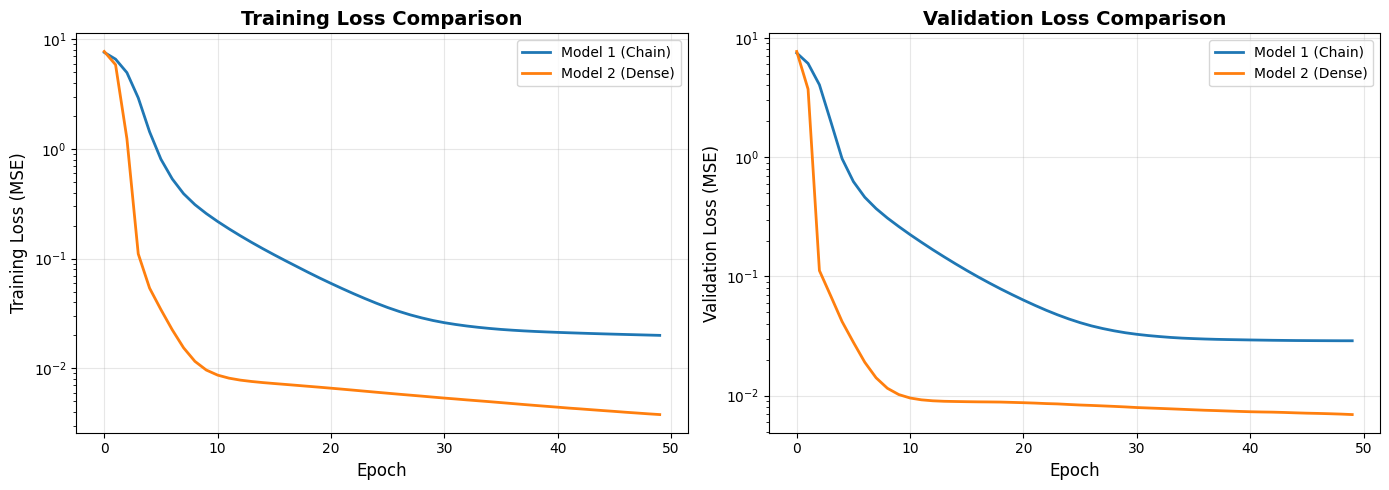

Final Training Loss - Model 1: 0.019948
Final Training Loss - Model 2: 0.003783

Final Validation Loss - Model 1: 0.028873
Final Validation Loss - Model 2: 0.006947


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training losses
axes[0].plot(history1['train_losses'], label='Model 1 (Chain)', linewidth=2)
axes[0].plot(history2['train_losses'], label='Model 2 (Dense)', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss (MSE)', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot validation losses
axes[1].plot(history1['val_losses'], label='Model 1 (Chain)', linewidth=2)
axes[1].plot(history2['val_losses'], label='Model 2 (Dense)', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Loss (MSE)', fontsize=12)
axes[1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Print final losses
print(f"Final Training Loss - Model 1: {history1['train_losses'][-1]:.6f}")
print(f"Final Training Loss - Model 2: {history2['train_losses'][-1]:.6f}")
print(f"\nFinal Validation Loss - Model 1: {history1['val_losses'][-1]:.6f}")
print(f"Final Validation Loss - Model 2: {history2['val_losses'][-1]:.6f}")

## Visualization: Singular Value Spectra for Model 1

Plot how the singular values of each block in Model 1 evolve during training.

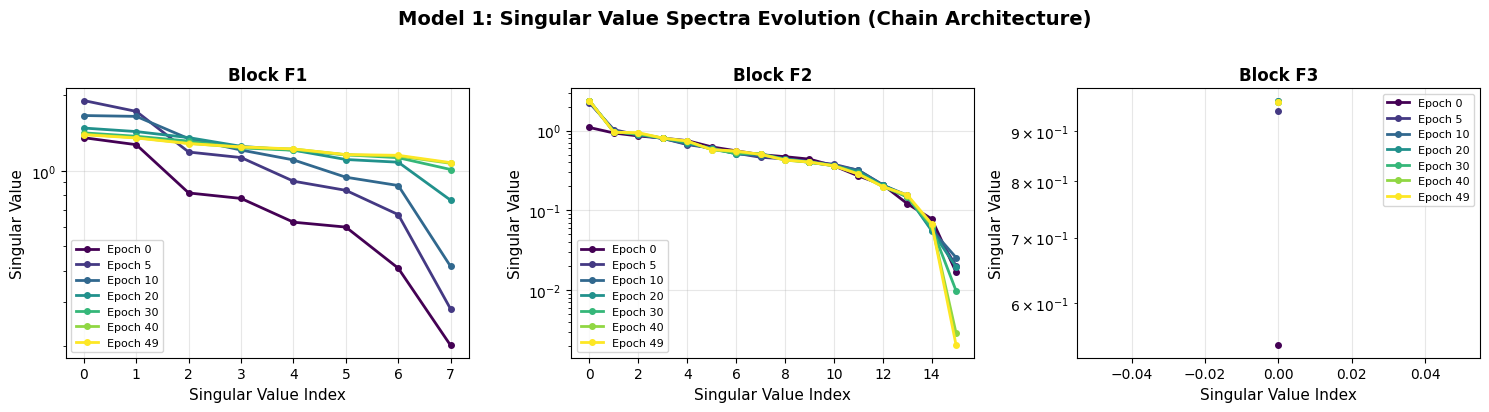

In [12]:
def plot_spectra_evolution_model1(history, layer_names):
    """
    Plot spectral evolution for Model 1 (3 blocks).
    """
    n_layers = len(layer_names)
    n_checkpoints = len(history['epochs'])
    
    fig, axes = plt.subplots(1, n_layers, figsize=(15, 4))
    if n_layers == 1:
        axes = [axes]
    
    colors = plt.cm.viridis(np.linspace(0, 1, n_checkpoints))
    
    for idx, layer_name in enumerate(layer_names):
        ax = axes[idx]
        
        for i, epoch in enumerate(history['epochs']):
            spectra = history['spectra'][epoch][layer_name]
            ax.plot(range(len(spectra)), spectra, 
                   color=colors[i], linewidth=2,
                   label=f'Epoch {epoch}', marker='o', markersize=4)
        
        ax.set_xlabel('Singular Value Index', fontsize=11)
        ax.set_ylabel('Singular Value', fontsize=11)
        ax.set_title(f'Block {layer_name}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    plt.suptitle('Model 1: Singular Value Spectra Evolution (Chain Architecture)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_spectra_evolution_model1(history1, ['F1', 'F2', 'F3'])

## Visualization: Singular Value Spectra for Model 2

Plot how the singular values of each block in Model 2 evolve during training.

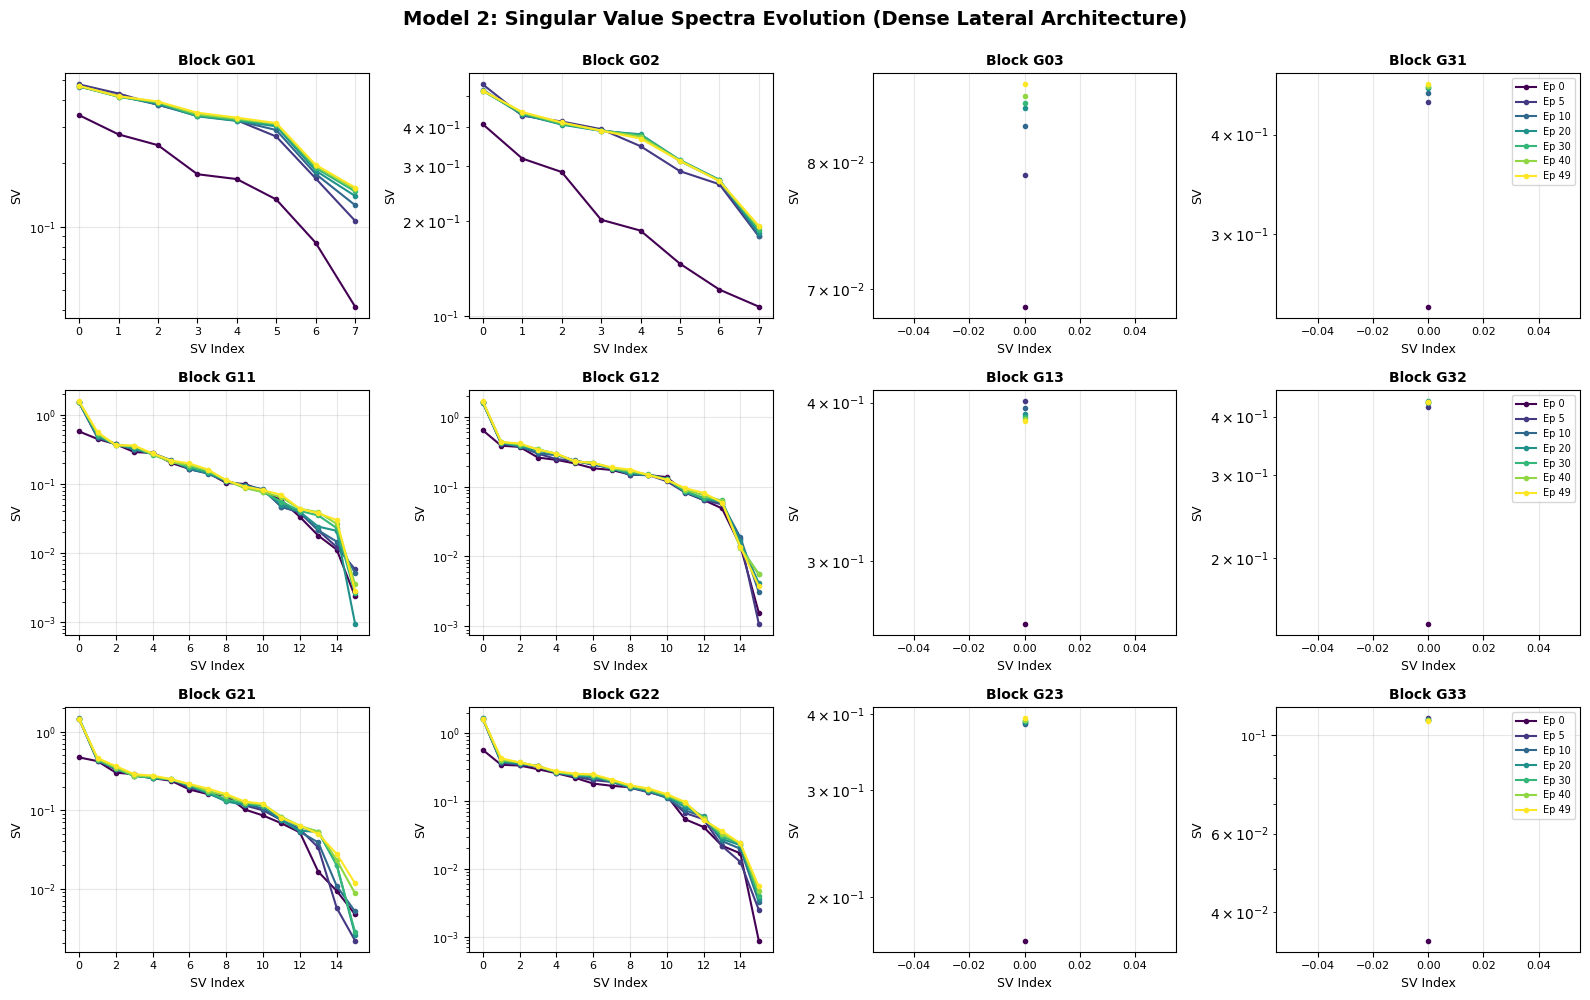

In [13]:
def plot_spectra_evolution_model2(history, layer_names):
    """
    Plot spectral evolution for Model 2 (12 blocks in a 3x4 grid).
    """
    n_checkpoints = len(history['epochs'])
    colors = plt.cm.viridis(np.linspace(0, 1, n_checkpoints))
    
    # Organize layers in a 3x4 grid (excluding first row/column)
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    
    layer_positions = [
        ('G01', 0, 0), ('G02', 0, 1), ('G03', 0, 2),
        ('G11', 1, 0), ('G12', 1, 1), ('G13', 1, 2),
        ('G21', 2, 0), ('G22', 2, 1), ('G23', 2, 2),
        ('G31', 0, 3), ('G32', 1, 3), ('G33', 2, 3)
    ]
    
    for layer_name, row, col in layer_positions:
        ax = axes[row, col]
        
        for i, epoch in enumerate(history['epochs']):
            spectra = history['spectra'][epoch][layer_name]
            ax.plot(range(len(spectra)), spectra, 
                   color=colors[i], linewidth=1.5,
                   label=f'Ep {epoch}', marker='o', markersize=3)
        
        ax.set_xlabel('SV Index', fontsize=9)
        ax.set_ylabel('SV', fontsize=9)
        ax.set_title(f'Block {layer_name}', fontsize=10, fontweight='bold')
        if col == 3:  # Only show legend on rightmost column
            ax.legend(fontsize=7, loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        ax.tick_params(labelsize=8)
    
    plt.suptitle('Model 2: Singular Value Spectra Evolution (Dense Lateral Architecture)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

plot_spectra_evolution_model2(history2, list(model2_layers.keys()))

## Visualization: Combined Spectra Comparison

Compare the sorted union of all singular values across both models at different training epochs.

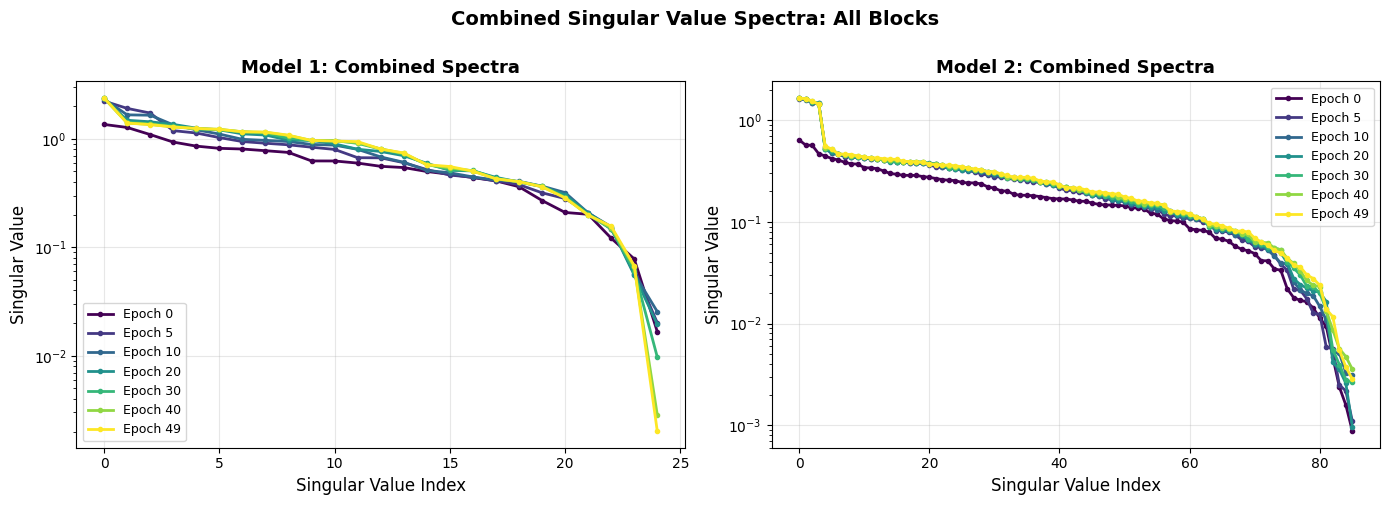

In [14]:
def plot_combined_spectra_comparison(history1, history2):
    """
    Plot the sorted union of all singular values for each model at each checkpoint.
    """
    n_checkpoints = len(history1['epochs'])
    colors = plt.cm.viridis(np.linspace(0, 1, n_checkpoints))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Model 1: Combined spectra
    ax = axes[0]
    for i, epoch in enumerate(history1['epochs']):
        # Concatenate all singular values and sort
        all_svs = []
        for layer_name, spectra in history1['spectra'][epoch].items():
            all_svs.extend(spectra)
        all_svs = np.sort(all_svs)[::-1]  # Sort descending
        
        ax.plot(range(len(all_svs)), all_svs, 
               color=colors[i], linewidth=2,
               label=f'Epoch {epoch}', marker='o', markersize=3)
    
    ax.set_xlabel('Singular Value Index', fontsize=12)
    ax.set_ylabel('Singular Value', fontsize=12)
    ax.set_title('Model 1: Combined Spectra', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Model 2: Combined spectra
    ax = axes[1]
    for i, epoch in enumerate(history2['epochs']):
        # Concatenate all singular values and sort
        all_svs = []
        for layer_name, spectra in history2['spectra'][epoch].items():
            all_svs.extend(spectra)
        all_svs = np.sort(all_svs)[::-1]  # Sort descending
        
        ax.plot(range(len(all_svs)), all_svs, 
               color=colors[i], linewidth=2,
               label=f'Epoch {epoch}', marker='o', markersize=3)
    
    ax.set_xlabel('Singular Value Index', fontsize=12)
    ax.set_ylabel('Singular Value', fontsize=12)
    ax.set_title('Model 2: Combined Spectra', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.suptitle('Combined Singular Value Spectra: All Blocks', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

plot_combined_spectra_comparison(history1, history2)

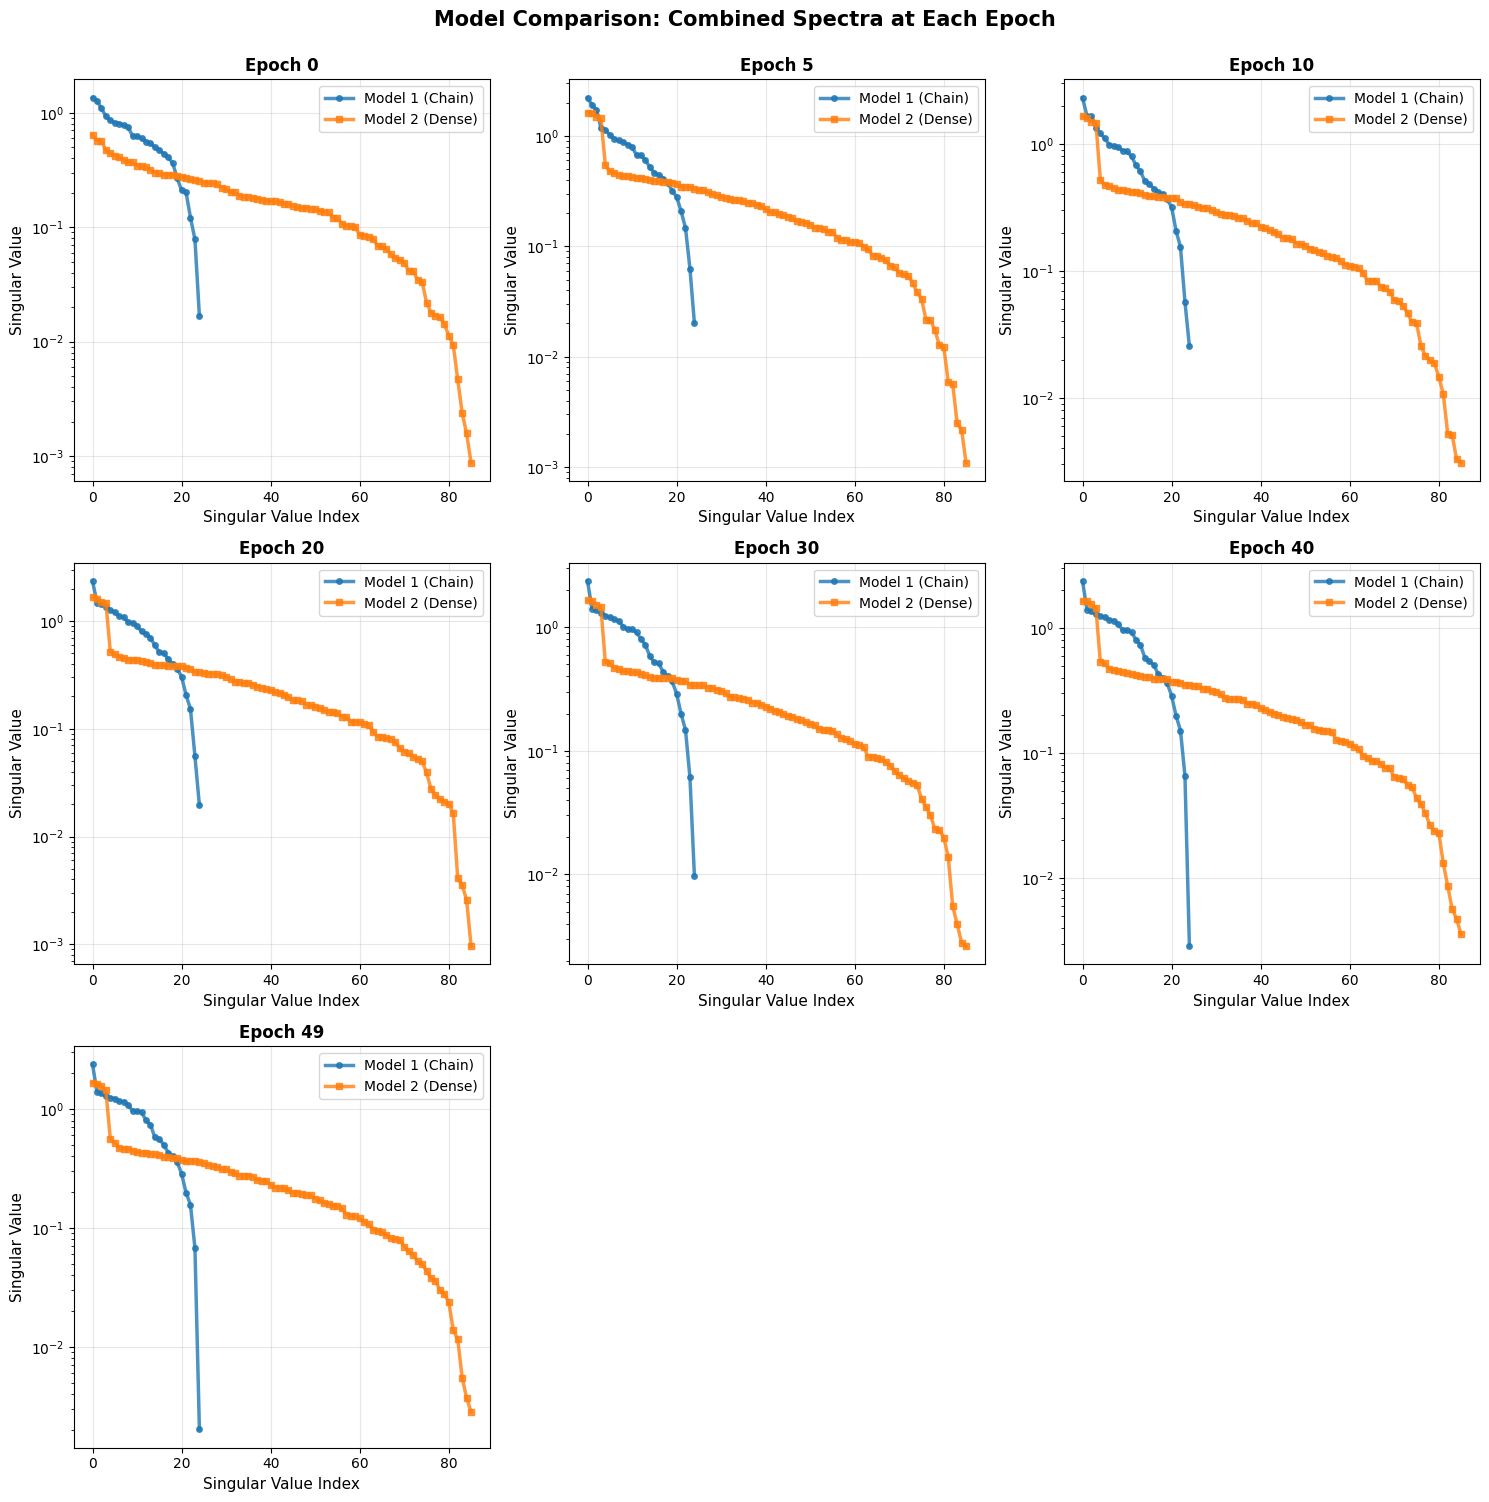

In [15]:
def plot_epoch_by_epoch_comparison(history1, history2):
    """
    Plot Model 1 vs Model 2 combined spectra for each checkpoint epoch.
    Each subplot shows both models at a specific training epoch.
    """
    n_checkpoints = len(history1['epochs'])
    
    # Determine grid layout for subplots
    n_cols = 3
    n_rows = int(np.ceil(n_checkpoints / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_checkpoints > 1 else [axes]
    
    for idx, epoch in enumerate(history1['epochs']):
        ax = axes[idx]
        
        # Model 1: Concatenate all singular values and sort
        all_svs_m1 = []
        for layer_name, spectra in history1['spectra'][epoch].items():
            all_svs_m1.extend(spectra)
        all_svs_m1 = np.sort(all_svs_m1)[::-1]  # Sort descending
        
        # Model 2: Concatenate all singular values and sort
        all_svs_m2 = []
        for layer_name, spectra in history2['spectra'][epoch].items():
            all_svs_m2.extend(spectra)
        all_svs_m2 = np.sort(all_svs_m2)[::-1]  # Sort descending
        
        # Plot both models
        ax.plot(range(len(all_svs_m1)), all_svs_m1, 
               color='#1f77b4', linewidth=2.5,
               label='Model 1 (Chain)', marker='o', markersize=4, alpha=0.8)
        ax.plot(range(len(all_svs_m2)), all_svs_m2, 
               color='#ff7f0e', linewidth=2.5,
               label='Model 2 (Dense)', marker='s', markersize=4, alpha=0.8)
        
        ax.set_xlabel('Singular Value Index', fontsize=11)
        ax.set_ylabel('Singular Value', fontsize=11)
        ax.set_title(f'Epoch {epoch}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    # Hide unused subplots
    for idx in range(n_checkpoints, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Model Comparison: Combined Spectra at Each Epoch', 
                 fontsize=15, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.show()

plot_epoch_by_epoch_comparison(history1, history2)

## Analysis: Condition Numbers

Examine the condition numbers of weight matrices over training.

The condition number $\kappa(W) = \sigma_{\max}/\sigma_{\min}$ measures numerical stability:
- Low condition number: well-conditioned matrix, numerically stable
- High condition number: ill-conditioned matrix, potential numerical issues


Condition Number Analysis: Model 1 (Chain)

Epoch 0:
  F1: κ = 6.73e+00
  F2: κ = 6.54e+01
  F3: κ = 1.00e+00

Epoch 5:
  F1: κ = 6.78e+00
  F2: κ = 1.10e+02
  F3: κ = 1.00e+00

Epoch 10:
  F1: κ = 4.00e+00
  F2: κ = 9.09e+01
  F3: κ = 1.00e+00

Epoch 20:
  F1: κ = 1.94e+00
  F2: κ = 1.21e+02
  F3: κ = 1.00e+00

Epoch 30:
  F1: κ = 1.40e+00
  F2: κ = 2.43e+02
  F3: κ = 1.00e+00

Epoch 40:
  F1: κ = 1.31e+00
  F2: κ = 8.30e+02
  F3: κ = 1.00e+00

Epoch 49:
  F1: κ = 1.29e+00
  F2: κ = 1.17e+03
  F3: κ = 1.00e+00



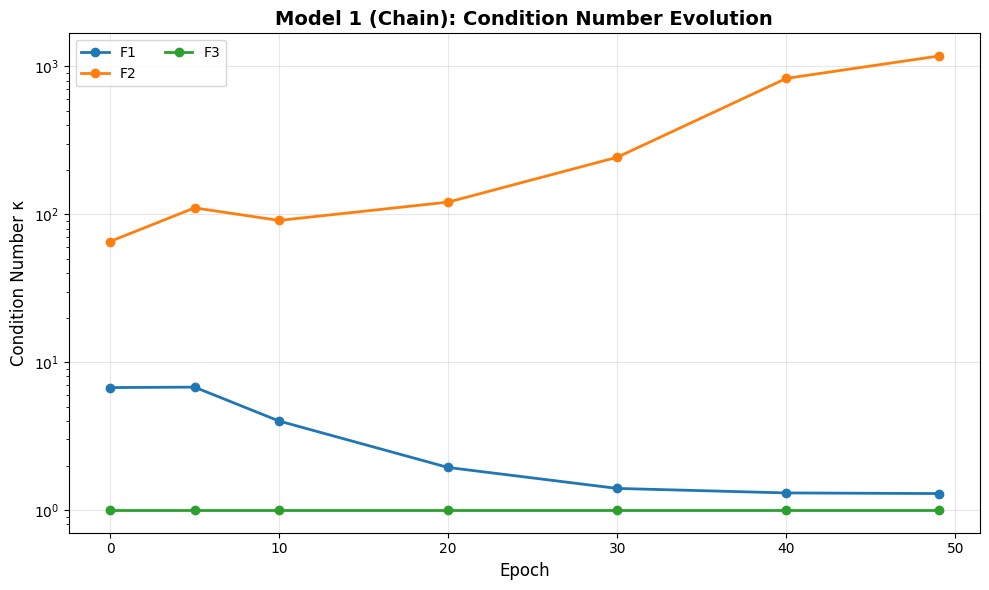


Condition Number Analysis: Model 2 (Dense)

Epoch 0:
  G01: κ = 8.18e+00
  G02: κ = 3.80e+00
  G03: κ = 1.00e+00
  G11: κ = 2.40e+02
  G12: κ = 4.07e+02
  G13: κ = 1.00e+00
  G21: κ = 1.00e+02
  G22: κ = 6.50e+02
  G23: κ = 1.00e+00
  G31: κ = 1.00e+00
  G32: κ = 1.00e+00
  G33: κ = 1.00e+00

Epoch 5:
  G01: κ = 4.47e+00
  G02: κ = 3.04e+00
  G03: κ = 1.00e+00
  G11: κ = 2.56e+02
  G12: κ = 1.47e+03
  G13: κ = 1.00e+00
  G21: κ = 6.68e+02
  G22: κ = 6.51e+02
  G23: κ = 1.00e+00
  G31: κ = 1.00e+00
  G32: κ = 1.00e+00
  G33: κ = 1.00e+00

Epoch 10:
  G01: κ = 3.67e+00
  G02: κ = 2.91e+00
  G03: κ = 1.00e+00
  G11: κ = 2.86e+02
  G12: κ = 5.19e+02
  G13: κ = 1.00e+00
  G21: κ = 2.89e+02
  G22: κ = 5.05e+02
  G23: κ = 1.00e+00
  G31: κ = 1.00e+00
  G32: κ = 1.00e+00
  G33: κ = 1.00e+00

Epoch 20:
  G01: κ = 3.33e+00
  G02: κ = 2.83e+00
  G03: κ = 1.00e+00
  G11: κ = 1.57e+03
  G12: κ = 3.89e+02
  G13: κ = 1.00e+00
  G21: κ = 5.69e+02
  G22: κ = 4.68e+02
  G23: κ = 1.00e+00
  G31: κ = 1.0

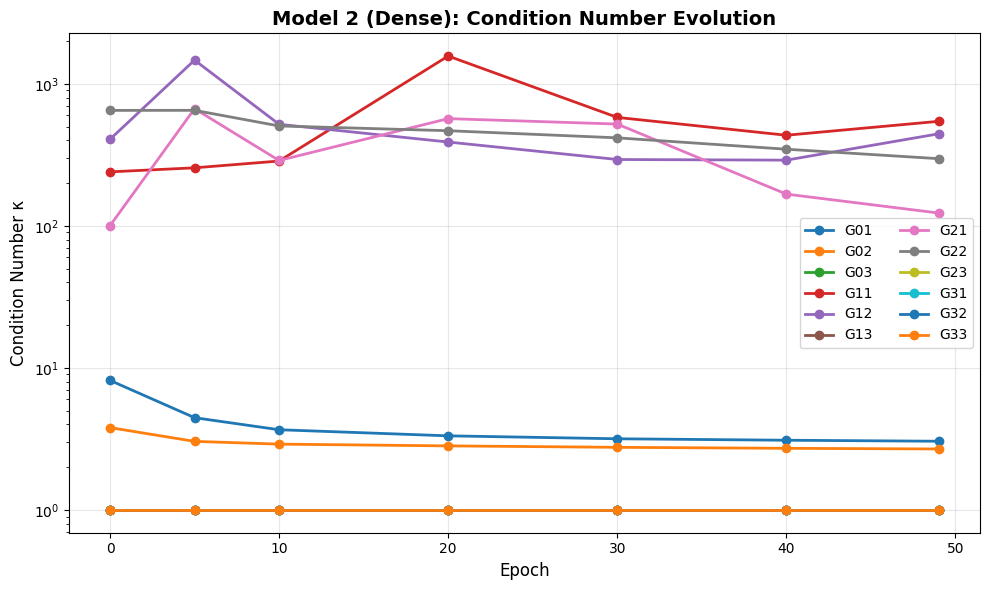

In [16]:
def analyze_condition_numbers(history, model_name):
    """
    Compute and display condition numbers for all blocks at each checkpoint.
    """
    print(f"\n{'='*70}")
    print(f"Condition Number Analysis: {model_name}")
    print(f"{'='*70}\n")
    
    # Collect condition numbers for each layer over time
    condition_numbers = {}
    
    for epoch in history['epochs']:
        print(f"Epoch {epoch}:")
        for layer_name, spectra in sorted(history['spectra'][epoch].items()):
            cond_num = compute_condition_number(spectra)
            
            if layer_name not in condition_numbers:
                condition_numbers[layer_name] = []
            condition_numbers[layer_name].append(cond_num)
            
            print(f"  {layer_name}: κ = {cond_num:.2e}")
        print()
    
    # Plot condition number evolution
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for layer_name, cond_nums in sorted(condition_numbers.items()):
        ax.plot(history['epochs'], cond_nums, marker='o', linewidth=2, label=layer_name)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Condition Number κ', fontsize=12)
    ax.set_title(f'{model_name}: Condition Number Evolution', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

analyze_condition_numbers(history1, 'Model 1 (Chain)')
analyze_condition_numbers(history2, 'Model 2 (Dense)')

## Analysis: Effective Rank

Compute the effective rank based on the singular value spectrum.

The effective rank captures how many singular values are "significant":

$$r_{\text{eff}} = \frac{\left(\sum_i \sigma_i\right)^2}{\sum_i \sigma_i^2}$$

This gives a continuous measure between 0 and the full rank.


Effective Rank Analysis: Model 1 (Chain)

Epoch 0:
  F1: r_eff = 6.45 (max = 8)
  F2: r_eff = 11.59 (max = 16)
  F3: r_eff = 1.00 (max = 1)

Epoch 5:
  F1: r_eff = 6.58 (max = 8)
  F2: r_eff = 8.96 (max = 16)
  F3: r_eff = 1.00 (max = 1)

Epoch 10:
  F1: r_eff = 7.18 (max = 8)
  F2: r_eff = 8.76 (max = 16)
  F3: r_eff = 1.00 (max = 1)

Epoch 20:
  F1: r_eff = 7.75 (max = 8)
  F2: r_eff = 8.66 (max = 16)
  F3: r_eff = 1.00 (max = 1)

Epoch 30:
  F1: r_eff = 7.92 (max = 8)
  F2: r_eff = 8.59 (max = 16)
  F3: r_eff = 1.00 (max = 1)

Epoch 40:
  F1: r_eff = 7.94 (max = 8)
  F2: r_eff = 8.59 (max = 16)
  F3: r_eff = 1.00 (max = 1)

Epoch 49:
  F1: r_eff = 7.95 (max = 8)
  F2: r_eff = 8.61 (max = 16)
  F3: r_eff = 1.00 (max = 1)



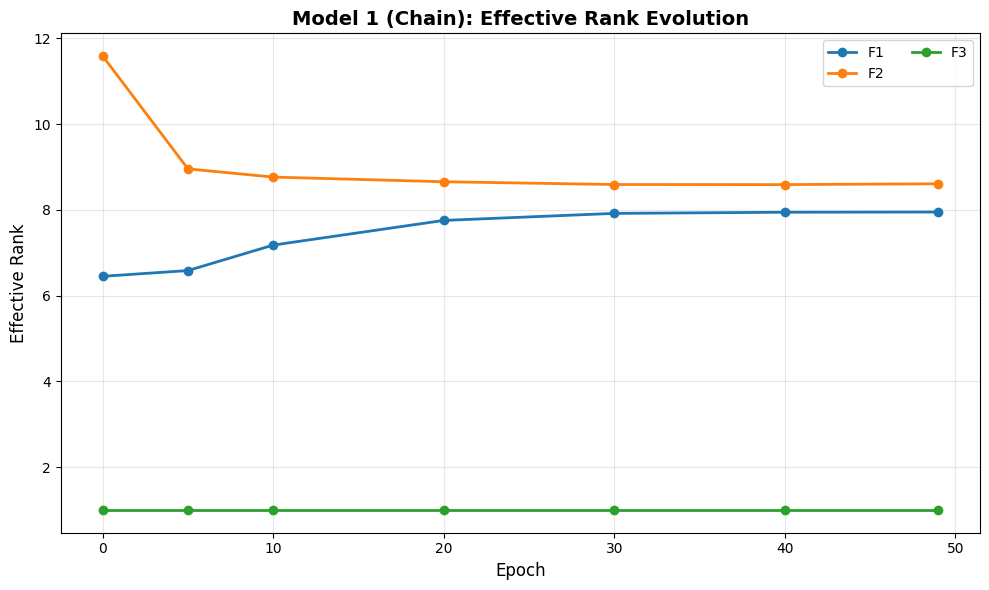


Effective Rank Analysis: Model 2 (Dense)

Epoch 0:
  G01: r_eff = 6.36 (max = 8)
  G02: r_eff = 6.68 (max = 8)
  G03: r_eff = 1.00 (max = 1)
  G11: r_eff = 8.73 (max = 16)
  G12: r_eff = 9.62 (max = 16)
  G13: r_eff = 1.00 (max = 1)
  G21: r_eff = 9.83 (max = 16)
  G22: r_eff = 9.70 (max = 16)
  G23: r_eff = 1.00 (max = 1)
  G31: r_eff = 1.00 (max = 1)
  G32: r_eff = 1.00 (max = 1)
  G33: r_eff = 1.00 (max = 1)

Epoch 5:
  G01: r_eff = 7.00 (max = 8)
  G02: r_eff = 7.35 (max = 8)
  G03: r_eff = 1.00 (max = 1)
  G11: r_eff = 5.15 (max = 16)
  G12: r_eff = 5.44 (max = 16)
  G13: r_eff = 1.00 (max = 1)
  G21: r_eff = 5.51 (max = 16)
  G22: r_eff = 5.20 (max = 16)
  G23: r_eff = 1.00 (max = 1)
  G31: r_eff = 1.00 (max = 1)
  G32: r_eff = 1.00 (max = 1)
  G33: r_eff = 1.00 (max = 1)

Epoch 10:
  G01: r_eff = 7.16 (max = 8)
  G02: r_eff = 7.44 (max = 8)
  G03: r_eff = 1.00 (max = 1)
  G11: r_eff = 5.16 (max = 16)
  G12: r_eff = 5.58 (max = 16)
  G13: r_eff = 1.00 (max = 1)
  G21: r_eff = 5.

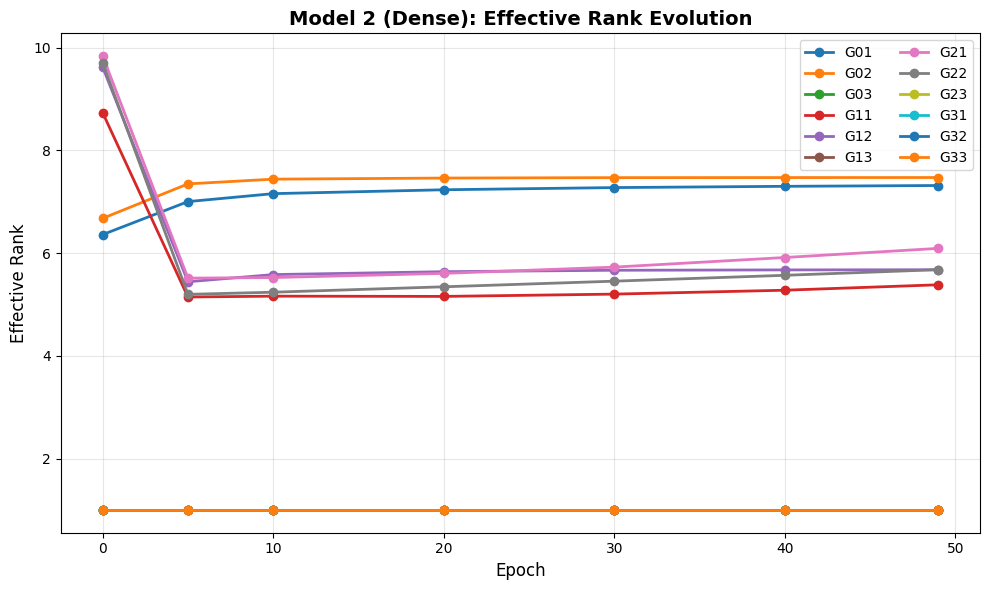

In [17]:
def compute_effective_rank(singular_values):
    """
    Compute effective rank from singular values.
    
    Args:
        singular_values: 1D array of singular values
    
    Returns:
        effective_rank: Scalar effective rank
    """
    sum_s = np.sum(singular_values)
    sum_s2 = np.sum(singular_values ** 2)
    
    if sum_s2 > 1e-10:
        return (sum_s ** 2) / sum_s2
    else:
        return 0.0

def analyze_effective_ranks(history, model_name):
    """
    Compute and display effective ranks for all blocks at each checkpoint.
    """
    print(f"\n{'='*70}")
    print(f"Effective Rank Analysis: {model_name}")
    print(f"{'='*70}\n")
    
    # Collect effective ranks for each layer over time
    effective_ranks = {}
    
    for epoch in history['epochs']:
        print(f"Epoch {epoch}:")
        for layer_name, spectra in sorted(history['spectra'][epoch].items()):
            eff_rank = compute_effective_rank(spectra)
            
            if layer_name not in effective_ranks:
                effective_ranks[layer_name] = []
            effective_ranks[layer_name].append(eff_rank)
            
            print(f"  {layer_name}: r_eff = {eff_rank:.2f} (max = {len(spectra)})")
        print()
    
    # Plot effective rank evolution
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for layer_name, eff_ranks in sorted(effective_ranks.items()):
        ax.plot(history['epochs'], eff_ranks, marker='o', linewidth=2, label=layer_name)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Effective Rank', fontsize=12)
    ax.set_title(f'{model_name}: Effective Rank Evolution', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, ncol=2)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_effective_ranks(history1, 'Model 1 (Chain)')
analyze_effective_ranks(history2, 'Model 2 (Dense)')

## Summary and Insights

### Key Observations

1. **Spectral Evolution**: During training, the singular value spectra of weight matrices change as the model learns the regression task.

2. **Architectural Differences**:
   - **Model 1 (Chain)**: Has fewer trainable matrices (3 blocks) with potentially larger individual impact
   - **Model 2 (Dense)**: Has more trainable matrices (12 blocks) allowing more flexible information flow

3. **Condition Numbers**: Track numerical stability of weight matrices. High condition numbers may indicate:
   - Sensitivity to input perturbations
   - Potential gradient flow issues
   - Need for regularization

4. **Effective Rank**: Measures the "dimensionality" being used by each weight matrix:
   - Low effective rank: matrix is approximately low-rank
   - High effective rank: matrix uses its full representational capacity

### Connections to Dynamical Systems

The Sequential2D architecture can be viewed as a discrete-time dynamical system:

$$\mathbf{z}_{t+1} = F(\mathbf{z}_t; \theta)$$

where $\mathbf{z}_t$ is the state at time $t$ and $\theta$ are the weight matrices. The singular value spectra provide insight into:

- **Stability**: Largest singular values relate to amplification/damping of signals
- **Sensitivity**: Condition numbers indicate how perturbations propagate
- **Dimensionality**: Effective rank shows the active subspace dimension

### Future Directions

1. Compare spectra for different regression tasks
2. Analyze spectral properties for classification problems
3. Study the relationship between spectra and generalization
4. Investigate regularization effects on spectral evolution